<a href="https://colab.research.google.com/github/matthewlerouxbusiness-pixel/Data-Science/blob/main/Forex_Currency_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import joblib
import re
!pip install streamlit pyngrok
!pip install streamlit
!pip install autots
import streamlit as st
from autots import AutoTS
from pyngrok import ngrok
%matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
#os.chdir("/content/drive/")
os.chdir("/content/drive/My Drive")
!ls

 churn-bigml-20.csv			     heart.csv
 climate_2009_2016.csv			     IRIS.csv
'Colab Notebooks'			    'Loan Prediction.csv'
 Cuisine_rating.csv			     Mall_Customers.csv
'Data_Science_Week_8_Assignment (3).ipynb'   models
 df_original.csv			     streamlit_app
 df_scaled.csv				     twitter_training.csv
 Diabetes-Classification.csv		     weather_data_extended.csv
 fitness_class_2212.csv			    'Week 8.ipynb'
 Foreign_Exchange_Rates.xls


In [3]:
#Read in the data file
df = pd.read_csv('Foreign_Exchange_Rates.xls')

In [4]:
#Print the shape of the data frame and show the first 5 rows
print(f'\nData Shape: {df.shape}')
df.head()


Data Shape: (5217, 25)


,Unnamed: 0,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,...,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$,Unnamed: 24
0,0,03-01-2000,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,...,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97,NaN
1,1,04-01-2000,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,...,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13,NaN
2,2,05-01-2000,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,...,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1,NaN
3,3,06-01-2000,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,...,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62,NaN
4,4,07-01-2000,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,...,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3,NaN


In [5]:
df.isnull().sum()

,0
Unnamed: 0,0
Time Serie,0
AUSTRALIA - AUSTRALIAN DOLLAR/US$,0
EURO AREA - EURO/US$,0
NEW ZEALAND - NEW ZELAND DOLLAR/US$,0
UNITED KINGDOM - UNITED KINGDOM POUND/US$,0
BRAZIL - REAL/US$,0
CANADA - CANADIAN DOLLAR/US$,0
CHINA - YUAN/US$,0
HONG KONG - HONG KONG DOLLAR/US$,0


In [6]:
#So we know two things to start off with:
#1. The 'unnamed: 0' column is just an index saved to the file, and does not represent any meaningful data
#2. The 'unnamed: 24' column is entirely filled with NaN values
#This means we want to get rid of both of these entirely

df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 24'])

In [7]:
#Next we want to deal with the date column
#I will rename it for greater clarity, and then convert it to a form that allows time-series anaylsis
df = df.rename(columns = {'Time Serie': 'date'})

df['date'] = pd.to_datetime(df['date'], format = '%d-%m-%Y', errors = 'coerce')  #The coerce will handle any malformed dates in the column

In [8]:
#Now I will set the date as index to help with time series analysis
df = df.set_index('date')

In [9]:
#I will also do a sanity check and convert all exchange rate columns to numeric values (in case some are stored as strings) so that they are all useable for the analysis
#This will also mean that any non-numeric values become NaN
df = df.apply(pd.to_numeric, errors = 'coerce')

In [10]:
#We can now see we have a lot of values now being correctly flagged as null when previously they were ignored
#Now we can properly deal with them
df.isnull().sum()

,0
AUSTRALIA - AUSTRALIAN DOLLAR/US$,198
EURO AREA - EURO/US$,198
NEW ZEALAND - NEW ZELAND DOLLAR/US$,198
UNITED KINGDOM - UNITED KINGDOM POUND/US$,198
BRAZIL - REAL/US$,198
CANADA - CANADIAN DOLLAR/US$,198
CHINA - YUAN/US$,197
HONG KONG - HONG KONG DOLLAR/US$,198
INDIA - INDIAN RUPEE/US$,199
KOREA - WON/US$,198


In [11]:
df = df.dropna()
#So far we have removed redundant columns, converted the 'time serie' column to a datetime index, coerced exchange rates to exclusively numerical values and handled the missing data

<Figure size 1400x600 with 0 Axes>

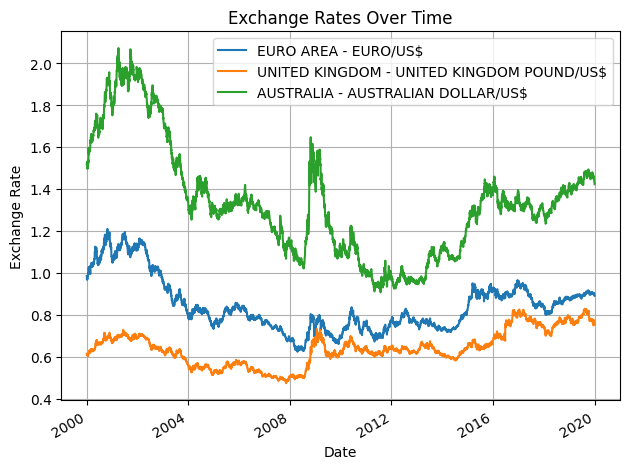

In [12]:
#Next we want to explore the time-series data using visualizations and correlation plots
#I will pick a few of the key currencies to plot for time-series visualisation so we can still see what is going on

plt.figure(figsize = (14, 6))

df[['EURO AREA - EURO/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'AUSTRALIA - AUSTRALIAN DOLLAR/US$']].plot()

plt.title('Exchange Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

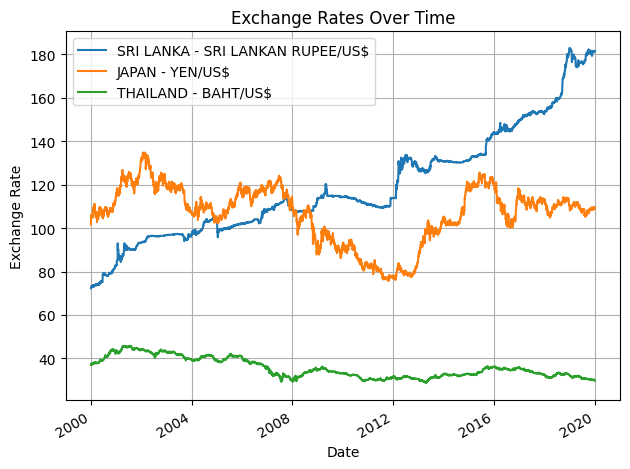

In [13]:
#Another plot with 3 different choices
plt.figure(figsize = (14, 6))

df[['SRI LANKA - SRI LANKAN RUPEE/US$', 'JAPAN - YEN/US$', 'THAILAND - BAHT/US$']].plot()

plt.title('Exchange Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

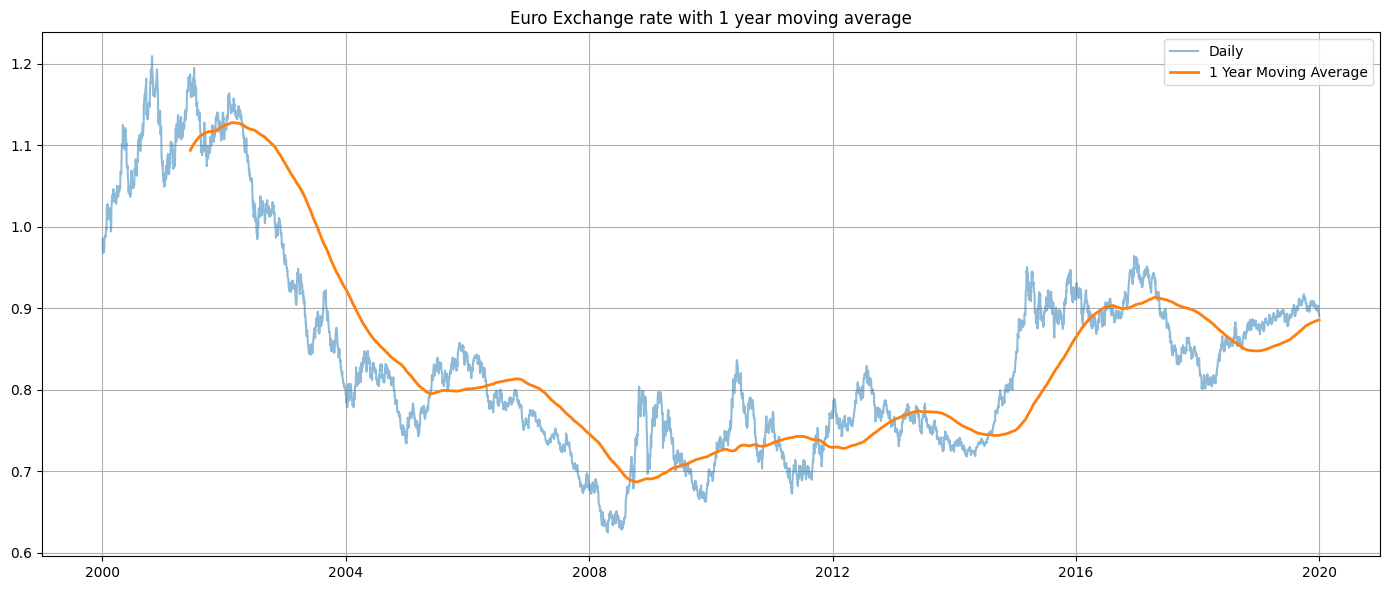

In [14]:
#We can also do an average over a given time period - here I will do it for a year
#This will allow us to gain clarity from the trends over the time period between 2000 and 2020, smoothing out the more jumpy curve we had originally
df['EURO_YEAR'] = df['EURO AREA - EURO/US$'].rolling(window = 365).mean()

plt.figure(figsize = (14,6))
plt.plot(df.index, df['EURO AREA - EURO/US$'], alpha = 0.5, label = 'Daily')
plt.plot(df.index, df['EURO_YEAR'], linewidth = 2, label = '1 Year Moving Average')

plt.title('Euro Exchange rate with 1 year moving average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

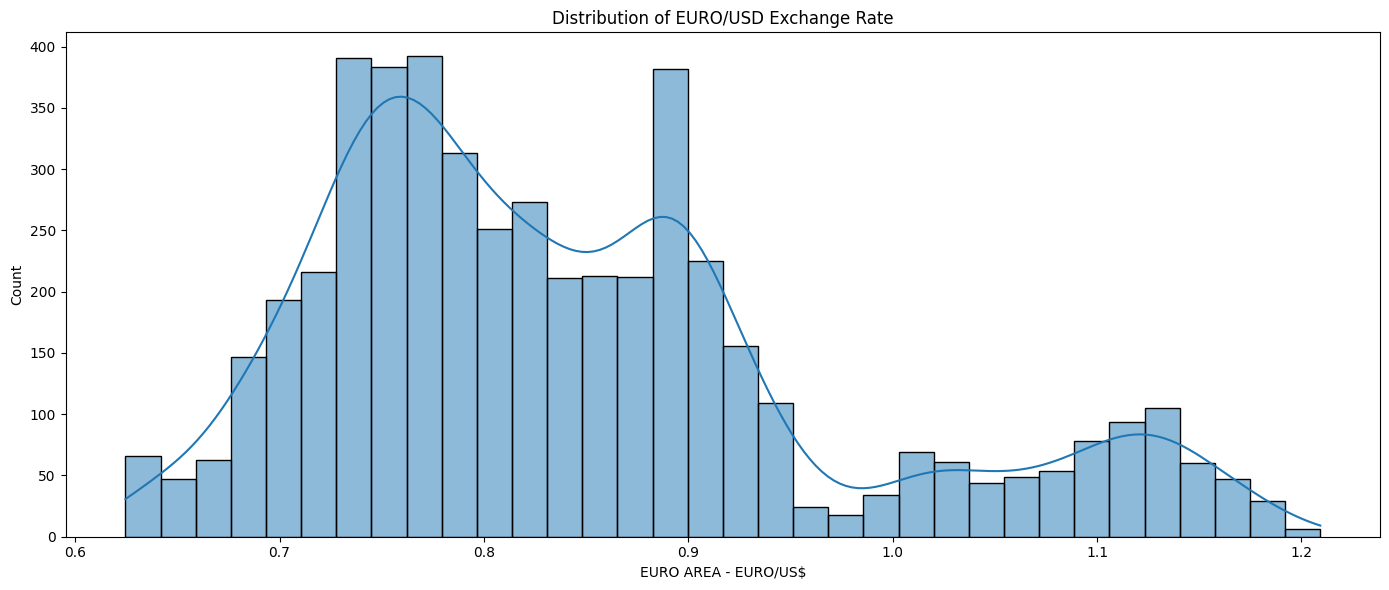

In [15]:
#Next we can do a distribution analysis

plt.figure(figsize = (14, 6))
sns.histplot(df['EURO AREA - EURO/US$'], kde = True)
plt.title('Distribution of EURO/USD Exchange Rate')
plt.tight_layout()
plt.show()

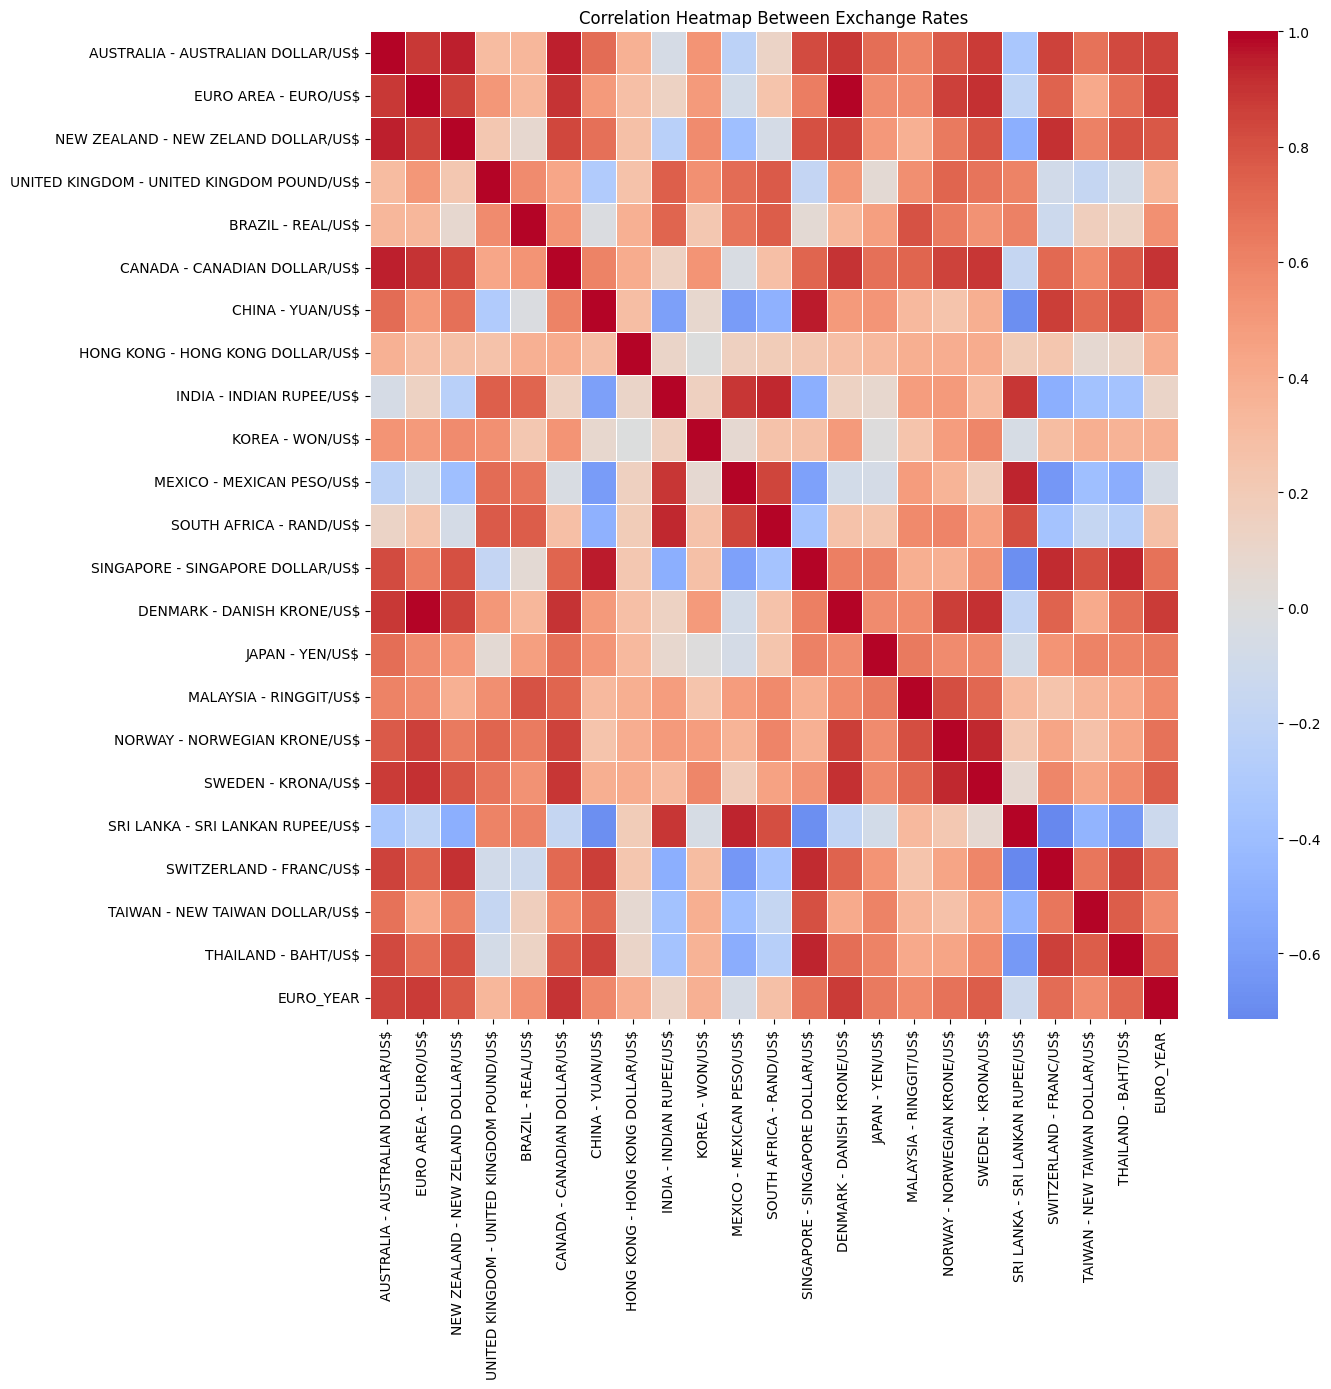

In [16]:
#Heatmap

corr = df.corr()
plt.figure(figsize = (14, 14))
sns.heatmap(corr, cmap = 'coolwarm', center = 0, linewidths = 0.5)
plt.title('Correlation Heatmap Between Exchange Rates')
plt.tight_layout()
plt.show()

In [17]:
#Now I will scale the data
fx_cols = df.columns

scaler = StandardScaler()

scaled_array = scaler.fit_transform(df[fx_cols])

df_scaled = pd.DataFrame(scaled_array, columns = [f'{c}_scaled' for c in fx_cols], index = df.index)

In [ ]:
#params
test_days = 60
look_back = 5   # for LSTM
currency_cols = [col for col in df_scaled.columns if '_scaled' in col]
results = []

def create_lags(series, n_lags=5):
    df_lags = pd.DataFrame()
    for lag in range(1, n_lags + 1):
        df_lags[f'lag_{lag}'] = series.shift(lag)
    df_lags['target'] = series
    return df_lags.dropna()

for currency in currency_cols:
    #Train test split
    train = df_scaled[currency][:-test_days]
    test = df_scaled[currency][-test_days:]

    #Ensure no NaNs
    train = train.fillna(method='ffill').fillna(method='bfill')
    test = test.fillna(method='ffill').fillna(method='bfill')

    #XGBoost
    lag_df = create_lags(train, n_lags=look_back)
    X_train = lag_df.drop('target', axis=1)
    y_train = lag_df['target']

    last_obs = train[-look_back:].tolist()
    preds_xgb = []
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model_xgb.fit(X_train, y_train)
    for i in range(test_days):
        x_input = np.array(last_obs[-look_back:]).reshape(1, -1)
        pred = model_xgb.predict(x_input)[0]
        preds_xgb.append(pred)
        last_obs.append(pred)

    mask = ~np.isnan(test) & ~np.isnan(preds_xgb)
    mae_xgb = mean_absolute_error(test[mask], np.array(preds_xgb)[mask])
    rmse_xgb = np.sqrt(mean_squared_error(test[mask], np.array(preds_xgb)[mask]))

    #LSTM
    train_values = train.values
    X_lstm, y_lstm = [], []
    for i in range(look_back, len(train_values)):
        X_lstm.append(train_values[i - look_back:i])
        y_lstm.append(train_values[i])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

    lstm_model = Sequential([
        LSTM(50, activation='tanh', input_shape=(X_lstm.shape[1], 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_lstm, y_lstm, epochs=50, verbose=0)

    test_values = train_values[-look_back:].tolist()
    preds_lstm = []
    for i in range(test_days):
        x_input = np.array(test_values[-look_back:]).reshape(1, look_back, 1)
        pred = lstm_model.predict(x_input, verbose=0)[0, 0]
        preds_lstm.append(pred)
        test_values.append(pred)

    mask = ~np.isnan(test) & ~np.isnan(preds_lstm)
    mae_lstm = mean_absolute_error(test[mask], np.array(preds_lstm)[mask])
    rmse_lstm = np.sqrt(mean_squared_error(test[mask], np.array(preds_lstm)[mask]))


    #ARIMA
    train_arima = df[currency.replace('_scaled','')][:-test_days]
    test_arima = df[currency.replace('_scaled','')][-test_days:]

    # ensure datetime index has daily frequency
    train_arima.index = pd.to_datetime(train_arima.index)
    train_arima = train_arima.asfreq('D')

    try:
      arima_model = ARIMA(train_arima, order=(5,1,0)).fit()
      preds_arima = arima_model.forecast(steps=test_days)
      mae_arima = mean_absolute_error(test_arima, preds_arima)
      rmse_arima = np.sqrt(mean_squared_error(test_arima, preds_arima))
    except:
      mae_arima = rmse_arima = np.nan



    #Prophet
    df_prophet = train.reset_index().rename(columns={'date': 'ds', currency: 'y'})
    prophet_model = Prophet(daily_seasonality=True)
    prophet_model.fit(df_prophet)
    future = prophet_model.make_future_dataframe(periods=test_days)
    forecast = prophet_model.predict(future)
    preds_prophet = forecast['yhat'][-test_days:].values
    mask = ~np.isnan(test) & ~np.isnan(preds_prophet)
    mae_prophet = mean_absolute_error(test[mask], np.array(preds_prophet)[mask])
    rmse_prophet = np.sqrt(mean_squared_error(test[mask], np.array(preds_prophet)[mask]))

    # Store results
    results.append({
        'Currency': currency.replace('_scaled', ''),
        'XGBoost_MAE': mae_xgb, 'XGBoost_RMSE': rmse_xgb,
        'LSTM_MAE': mae_lstm, 'LSTM_RMSE': rmse_lstm,
        'ARIMA_MAE': mae_arima, 'ARIMA_RMSE': rmse_arima,
        'Prophet_MAE': mae_prophet, 'Prophet_RMSE': rmse_prophet
    })

# Comparison table
results_df = pd.DataFrame(results)
print(results_df)

In [18]:
#From this data, I can see tha the 'SWITZERLAND - FRANC/US$' performs the best across all models
#We can also see that ARIMA dominates most of the major, stable currencies

#For now let's choose one currency to work with
#-> the EURO AREA - EURO/US currency has its best performance using the ARIMA model, so let's save that using joblib

#Start by re-fitting ARIMA on the full series

eur_series = df['EURO AREA - EURO/US$']
eur_series.index = pd.to_datetime(eur_series.index)
eur_series = eur_series.asfreq('D')

eur_arima = ARIMA(eur_series, order = (5, 1, 0)).fit()

In [19]:
#Saving the model
#os.makedirs("models", exist_ok=True)
joblib.dump(eur_arima, 'models/EUR_ARIMA.pkl')

#Instead of doing this manually for the best model for each currency, I have decided to markdown my previous loop and will now
#Create a version that saves the best currency model in the models folder

['models/EUR_ARIMA.pkl']

In [20]:
#params
test_days = 60
look_back = 5
currency_cols = [col for col in df_scaled.columns if '_scaled' in col]

#Ensure models folder exists
os.makedirs('models', exist_ok=True)

def create_lags(series, n_lags=5):
    df_lags = pd.DataFrame()
    for lag in range(1, n_lags + 1):
        df_lags[f'lag_{lag}'] = series.shift(lag)
    df_lags['target'] = series
    return df_lags.dropna()

for currency in currency_cols:
    print(f"Processing {currency.replace('_scaled','')} ...")

    #train test split
    train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
    test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')

    #XGBoost
    lag_df = create_lags(train, n_lags=look_back)
    X_train = lag_df.drop('target', axis=1)
    y_train = lag_df['target']
    last_obs = train[-look_back:].tolist()
    preds_xgb = []

    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model_xgb.fit(X_train, y_train)

    for i in range(test_days):
        x_input = np.array(last_obs[-look_back:]).reshape(1, -1)
        pred = model_xgb.predict(x_input)[0]
        preds_xgb.append(pred)
        last_obs.append(pred)

    mask = ~np.isnan(test) & ~np.isnan(preds_xgb)
    mae_xgb = mean_absolute_error(test[mask], np.array(preds_xgb)[mask])
    rmse_xgb = np.sqrt(mean_squared_error(test[mask], np.array(preds_xgb)[mask]))

    #LSTM
    train_values = train.values
    X_lstm, y_lstm = [], []
    for i in range(look_back, len(train_values)):
        X_lstm.append(train_values[i - look_back:i])
        y_lstm.append(train_values[i])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

    lstm_model = Sequential([
        LSTM(50, activation='tanh', input_shape=(X_lstm.shape[1], 1)),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_lstm, y_lstm, epochs=50, verbose=0)

    test_values = train_values[-look_back:].tolist()
    preds_lstm = []
    for i in range(test_days):
        x_input = np.array(test_values[-look_back:]).reshape(1, look_back, 1)
        pred = lstm_model.predict(x_input, verbose=0)[0, 0]
        preds_lstm.append(pred)
        test_values.append(pred)

    mask = ~np.isnan(test) & ~np.isnan(preds_lstm)
    mae_lstm = mean_absolute_error(test[mask], np.array(preds_lstm)[mask])
    rmse_lstm = np.sqrt(mean_squared_error(test[mask], np.array(preds_lstm)[mask]))

    #ARIMA
    train_arima = df[currency.replace('_scaled','')][:-test_days]
    test_arima = df[currency.replace('_scaled','')][-test_days:]

    train_arima.index = pd.to_datetime(train_arima.index)
    train_arima = train_arima.asfreq('D')

    try:
        arima_model = ARIMA(train_arima, order=(5,1,0)).fit()
        preds_arima = arima_model.forecast(steps=test_days)
        mae_arima = mean_absolute_error(test_arima, preds_arima)
        rmse_arima = np.sqrt(mean_squared_error(test_arima, preds_arima))
    except:
        mae_arima = rmse_arima = np.nan
        arima_model = None

    #Prophet
    df_prophet = train.reset_index().rename(columns={'date': 'ds', currency: 'y'})
    prophet_model = Prophet(daily_seasonality=True)
    prophet_model.fit(df_prophet)
    future = prophet_model.make_future_dataframe(periods=test_days)
    forecast = prophet_model.predict(future)
    preds_prophet = forecast['yhat'][-test_days:].values
    mask = ~np.isnan(test) & ~np.isnan(preds_prophet)
    mae_prophet = mean_absolute_error(test[mask], np.array(preds_prophet)[mask])
    rmse_prophet = np.sqrt(mean_squared_error(test[mask], np.array(preds_prophet)[mask]))

    #Select and save best model
    mae_dict = {
        'XGBoost': mae_xgb,
        'LSTM': mae_lstm,
        'ARIMA': mae_arima,
        'Prophet': mae_prophet
    }
    best_model_name = min(mae_dict, key=mae_dict.get)


    # create a safe filename
    safe_name = re.sub(r'[^\w\-_\.]', '_', currency.replace('_scaled',''))

    if best_model_name == 'XGBoost':
      joblib.dump(model_xgb, f'models/{safe_name}_XGB.pkl')
    elif best_model_name == 'LSTM':
      lstm_model.save(f'models/{safe_name}_LSTM.h5')
    elif best_model_name == 'ARIMA' and arima_model is not None:
      joblib.dump(arima_model, f'models/{safe_name}_ARIMA.pkl')
    elif best_model_name == 'Prophet':
      joblib.dump(prophet_model, f'models/{safe_name}_Prophet.pkl')

    print(f"{safe_name} - Best Model: {best_model_name}")

Processing AUSTRALIA - AUSTRALIAN DOLLAR/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AUSTRALIA_-_AUSTRALIAN_DOLLAR_US_ - Best Model: ARIMA
Processing EURO AREA - EURO/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


EURO_AREA_-_EURO_US_ - Best Model: ARIMA
Processing NEW ZEALAND - NEW ZELAND DOLLAR/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NEW_ZEALAND_-_NEW_ZELAND_DOLLAR_US_ - Best Model: ARIMA
Processing UNITED KINGDOM - UNITED KINGDOM POUND/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

UNITED_KINGDOM_-_UNITED_KINGDOM_POUND_US_ - Best Model: ARIMA
Processing BRAZIL - REAL/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


BRAZIL_-_REAL_US_ - Best Model: ARIMA
Processing CANADA - CANADIAN DOLLAR/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


CANADA_-_CANADIAN_DOLLAR_US_ - Best Model: ARIMA
Processing CHINA - YUAN/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][

CHINA_-_YUAN_US_ - Best Model: LSTM
Processing HONG KONG - HONG KONG DOLLAR/US$ ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


HONG_KONG_-_HONG_KONG_DOLLAR_US_ - Best Model: ARIMA
Processing INDIA - INDIAN RUPEE/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


INDIA_-_INDIAN_RUPEE_US_ - Best Model: XGBoost
Processing KOREA - WON/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][

KOREA_-_WON_US_ - Best Model: LSTM
Processing MEXICO - MEXICAN PESO/US$ ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MEXICO_-_MEXICAN_PESO_US_ - Best Model: XGBoost
Processing SOUTH AFRICA - RAND/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][

SOUTH_AFRICA_-_RAND_US_ - Best Model: LSTM
Processing SINGAPORE - SINGAPORE DOLLAR/US$ ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SINGAPORE_-_SINGAPORE_DOLLAR_US_ - Best Model: ARIMA
Processing DENMARK - DANISH KRONE/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


DENMARK_-_DANISH_KRONE_US_ - Best Model: ARIMA
Processing JAPAN - YEN/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


JAPAN_-_YEN_US_ - Best Model: XGBoost
Processing MALAYSIA - RINGGIT/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

MALAYSIA_-_RINGGIT_US_ - Best Model: ARIMA
Processing NORWAY - NORWEGIAN KRONE/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NORWAY_-_NORWEGIAN_KRONE_US_ - Best Model: ARIMA
Processing SWEDEN - KRONA/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SWEDEN_-_KRONA_US_ - Best Model: XGBoost
Processing SRI LANKA - SRI LANKAN RUPEE/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SRI_LANKA_-_SRI_LANKAN_RUPEE_US_ - Best Model: XGBoost
Processing SWITZERLAND - FRANC/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SWITZERLAND_-_FRANC_US_ - Best Model: ARIMA
Processing TAIWAN - NEW TAIWAN DOLLAR/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TAIWAN_-_NEW_TAIWAN_DOLLAR_US_ - Best Model: Prophet
Processing THAILAND - BAHT/US$ ...


/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][:-test_days].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-319246416.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = df_scaled[currency][-test_days:].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-319246416.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = df_scaled[currency][

THAILAND_-_BAHT_US_ - Best Model: LSTM
Processing EURO_YEAR ...
EURO_YEAR - Best Model: ARIMA


In [21]:
#Now that we want to build the streamlit app, we want to save our original and scaled data to csv files so that the streamlit app can load it
#scaled data
df_scaled.to_csv('df_scaled.csv')

#original data
df.to_csv('df_original.csv')

In [ ]:
#user params
st.title("Currency Forecast App")

#load available currencies from models folder
model_files = os.listdir('models')
currencies = sorted(set(re.sub(r'_(XGB|LSTM|ARIMA|Prophet)\..*', '', f) for f in model_files))
currency_choice = st.selectbox("Select Currency", currencies)
forecast_days = st.number_input("Forecast Horizon (days)", min_value=1, max_value=365, value=30)


# Load Historical Data
# Load scaled and original data
df_scaled = pd.read_csv('df_scaled.csv', index_col=0, parse_dates=True)
df_original = pd.read_csv('df_original.csv', index_col=0, parse_dates=True)

look_back = 5  # for LSTM


# Forecast Function
def make_forecast(currency, days):
    safe_name = re.sub(r'[^\w\-_\.]', '_', currency)
    files = [f for f in model_files if f.startswith(safe_name)]
    if not files:
        st.error(f"No saved model found for {currency}.")
        return None

    model_file = files[0]
    model_path = os.path.join('models', model_file)

    #Prophet
    if model_file.endswith("Prophet.pkl"):
        model = joblib.load(model_path)
        future = model.make_future_dataframe(periods=days)
        forecast = model.predict(future)
        return forecast[['ds','yhat']].tail(days)

    #ARIMA
    elif model_file.endswith("ARIMA.pkl"):
        model = joblib.load(model_path)
        last_index = df_original.index[-1]
        forecast_index = pd.date_range(last_index + pd.Timedelta(days=1), periods=days)
        preds = model.forecast(steps=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    #XGBoost
    elif model_file.endswith("XGB.pkl"):
        model = joblib.load(model_path)
        series = df_scaled[currency].values
        last_obs = series[-look_back:].tolist()
        preds = []
        for _ in range(days):
            x_input = np.array(last_obs[-look_back:]).reshape(1, -1)
            pred = model.predict(x_input)[0]
            preds.append(pred)
            last_obs.append(pred)
        forecast_index = pd.date_range(df_scaled.index[-1] + pd.Timedelta(days=1), periods=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    #LSTM
    elif model_file.endswith("LSTM.h5"):
        model = load_model(model_path)
        series = df_scaled[currency].values
        last_obs = series[-look_back:].tolist()
        preds = []
        for _ in range(days):
            x_input = np.array(last_obs[-look_back:]).reshape(1, look_back, 1)
            pred = model.predict(x_input, verbose=0)[0,0]
            preds.append(pred)
            last_obs.append(pred)
        forecast_index = pd.date_range(df_scaled.index[-1] + pd.Timedelta(days=1), periods=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    else:
        st.error("Unknown model type.")
        return None

#run forecast

forecast_df = make_forecast(currency_choice, forecast_days)
if forecast_df is not None:
    st.subheader(f"{currency_choice} Forecast")
    st.dataframe(forecast_df)
    if 'ds' in forecast_df.columns:
        st.line_chart(forecast_df.set_index('ds')['yhat'])
    else:
        st.line_chart(forecast_df.set_index('date')['forecast'])

#Need to write this into an 'app.py' text file within my google drive (test example)
file_path = '/content/drive/MyDrive/streamlit_app/app.py'
app_code = """
import streamlit as st
import pandas as pd
import joblib

# Example dropdown
currency_choice = st.selectbox("Select Currency", ["EURO", "USD", "JPY"])
forecast_days = st.number_input("Forecast Days", min_value=1, max_value=365, value=30)

# Example make_forecast() placeholder
def make_forecast(currency, days):
    # load model here and return DataFrame with columns ['ds', 'yhat']
    return pd.DataFrame({
        'ds': pd.date_range(start='2025-01-01', periods=days),
        'yhat': [1.0]*days
    })

forecast_df = make_forecast(currency_choice, forecast_days)
if forecast_df is not None:
    st.subheader(f"{currency_choice} Forecast")
    st.dataframe(forecast_df)
    st.line_chart(forecast_df.set_index('ds')['yhat'])
"""

with open(file_path, 'w') as f:
    f.write(app_code)

#Now that I have verified that the 'app.py' process will working using the above test code, I can now write into the file the full app code

file_path = '/content/drive/MyDrive/streamlit_app/app.py'

app_code = """
import streamlit as st
import pandas as pd
import os
import re
import joblib
from tensorflow.keras.models import load_model

st.title("Currency Forecast App")

#load the scaled and original data
df_scaled = pd.read_csv('df_scaled.csv', index_col=0, parse_dates=True)
df_original = pd.read_csv('df_original.csv', index_col=0, parse_dates=True)

look_back = 5  # for LSTM

#load the available currencies from models folder
model_files = os.listdir('models')
currencies = sorted(set(re.sub(r'_(XGB|LSTM|ARIMA|Prophet)\\..*', '', f) for f in model_files))
currency_choice = st.selectbox("Select Currency", currencies)
forecast_days = st.number_input("Forecast Horizon (days)", min_value=1, max_value=365, value=30)

def make_forecast(currency, days):
    safe_name = re.sub(r'[^\\w\\-_\\.]', '_', currency)
    files = [f for f in model_files if f.startswith(safe_name)]
    if not files:
        st.error(f"No saved model found for {currency}.")
        return None

    model_file = files[0]
    model_path = os.path.join('models', model_file)

    if model_file.endswith("Prophet.pkl"):
        model = joblib.load(model_path)
        future = model.make_future_dataframe(periods=days)
        forecast = model.predict(future)
        return forecast[['ds','yhat']].tail(days)

    elif model_file.endswith("ARIMA.pkl"):
        model = joblib.load(model_path)
        last_index = df_original.index[-1]
        forecast_index = pd.date_range(last_index + pd.Timedelta(days=1), periods=days)
        preds = model.forecast(steps=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    elif model_file.endswith("XGB.pkl"):
        model = joblib.load(model_path)
        series = df_scaled[f'{currency}_scaled'].values
        last_obs = series[-look_back:].tolist()
        preds = []
        for _ in range(days):
            x_input = pd.DataFrame([last_obs], columns=[f'lag_{i+1}' for i in range(look_back)])
            pred = model.predict(x_input)[0]
            preds.append(pred)
            last_obs.append(pred)
        forecast_index = pd.date_range(df_scaled.index[-1] + pd.Timedelta(days=1), periods=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    elif model_file.endswith("LSTM.h5"):
        model = load_model(model_path)
        series = df_scaled[f'{currency}_scaled'].values
        last_obs = series[-look_back:].tolist()
        preds = []
        for _ in range(days):
            x_input = pd.DataFrame([last_obs]).values.reshape(1, look_back, 1)
            pred = model.predict(x_input, verbose=0)[0,0]
            preds.append(pred)
            last_obs.append(pred)
        forecast_index = pd.date_range(df_scaled.index[-1] + pd.Timedelta(days=1), periods=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    else:
        st.error("Unknown model type.")
        return None

forecast_df = make_forecast(currency_choice, forecast_days)
if forecast_df is not None:
    st.subheader(f"{currency_choice} Forecast")
    st.dataframe(forecast_df)
    if 'ds' in forecast_df.columns:
        st.line_chart(forecast_df.set_index('ds')['yhat'])
    else:
        st.line_chart(forecast_df.set_index('date')['forecast'])
"""

with open(file_path, 'w') as f:
    f.write(app_code)

In [22]:
file_path = '/content/drive/MyDrive/streamlit_app/app.py'

app_code = """
import streamlit as st
import pandas as pd
import os
import re
import joblib
from tensorflow.keras.models import load_model

st.title("Currency Forecast App")

#load scaled and original data
df_scaled = pd.read_csv('df_scaled.csv', index_col=0, parse_dates=True)
df_original = pd.read_csv('df_original.csv', index_col=0, parse_dates=True)

look_back = 5  # for LSTM/XGB

#load available currencies from models folder
model_files = os.listdir('models')
currencies = sorted(set(re.sub(r'_(XGB|LSTM|ARIMA|Prophet)\\\\..*', '', f) for f in model_files))
currency_choice = st.selectbox("Select Currency", currencies)
forecast_days = st.number_input("Forecast Horizon (days)", min_value=1, max_value=365, value=30)

#forecast function
def make_forecast(currency, days):
    # Find model file for this currency
    files = [f for f in model_files if f.startswith(currency)]
    if not files:
        st.error(f"No saved model found for {currency}.")
        return None

    model_file = files[0]
    model_path = os.path.join('models', model_file)

    #Prophet
    if model_file.endswith("Prophet.pkl"):
        model = joblib.load(model_path)
        future = model.make_future_dataframe(periods=days)
        forecast = model.predict(future)
        return forecast[['ds','yhat']].tail(days)

    #ARIMA
    elif model_file.endswith("ARIMA.pkl"):
        model = joblib.load(model_path)
        last_index = df_original.index[-1]
        forecast_index = pd.date_range(last_index + pd.Timedelta(days=1), periods=days)
        preds = model.forecast(steps=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    #XGBoost
    elif model_file.endswith("XGB.pkl"):
        model = joblib.load(model_path)
        # Use scaled column if exists
        if f"{currency}_scaled" in df_scaled.columns:
            series_col = f"{currency}_scaled"
        elif currency in df_scaled.columns:
            series_col = currency
        else:
            st.error(f"No matching column found for {currency}")
            return None

        series = df_scaled[series_col].values
        last_obs = series[-look_back:].tolist()
        preds = []
        for _ in range(days):
            x_input = pd.DataFrame([last_obs], columns=[f'lag_{i+1}' for i in range(look_back)])
            pred = model.predict(x_input)[0]
            preds.append(pred)
            last_obs.append(pred)

        forecast_index = pd.date_range(df_scaled.index[-1] + pd.Timedelta(days=1), periods=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    #LSTM
    elif model_file.endswith("LSTM.h5"):
        # Load LSTM without compiling to avoid mse issues
        model = load_model(model_path, compile=False)

        # Use scaled column if exists
        if f"{currency}_scaled" in df_scaled.columns:
            series_col = f"{currency}_scaled"
        elif currency in df_scaled.columns:
            series_col = currency
        else:
            st.error(f"No matching column found for {currency}")
            return None

        series = df_scaled[series_col].values
        last_obs = series[-look_back:].tolist()
        preds = []
        for _ in range(days):
            x_input = pd.DataFrame([last_obs]).values.reshape(1, look_back, 1)
            pred = model.predict(x_input, verbose=0)[0,0]
            preds.append(pred)
            last_obs.append(pred)

        forecast_index = pd.date_range(df_scaled.index[-1] + pd.Timedelta(days=1), periods=days)
        return pd.DataFrame({'date': forecast_index, 'forecast': preds})

    else:
        st.error("Unknown model type.")
        return None

#run forecast
forecast_df = make_forecast(currency_choice, forecast_days)
if forecast_df is not None:
    st.subheader(f"{currency_choice} Forecast")
    st.dataframe(forecast_df)
    if 'ds' in forecast_df.columns:
        st.line_chart(forecast_df.set_index('ds')['yhat'])
    else:
        st.line_chart(forecast_df.set_index('date')['forecast'])
"""

with open(file_path, 'w') as f:
    f.write(app_code)

In [23]:
#Since I am using google colab, I also need an ngrok authtoken to run the app
!ngrok authtoken 37cSGr1X4hasp7v14AZ7liRYbpI_SSuXarK3q23h44X3ZUBS

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [24]:
#Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(8501, proto="http")  # port as int
print(public_url)

#Run streamlit
!streamlit run "/content/drive/MyDrive/streamlit_app/app.py" &

NgrokTunnel: "https://dodgily-euphonic-jacklyn.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.127.14.85:8501

2026-01-02 18:06:00.222269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767377160.294569  120129 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767377160.316891  120129 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767377160.391601  120129 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than onc